## 1. Setup

The tool was developped based on the following dependencies:

1. PyTorch (1.1 or greater).
2. NumPy (1.16 or greater).
3. tqdm (4.31 or greater).

Please note that the dependencies may require Python version 3.6 or greater. It is recommemded to install and maintain all dependencies by using [`conda`](https://www.anaconda.com/) or [`pip`](https://pypi.org/project/pip/). For PyTorch installation, especially when GPU acceleration is needed, additional effort may be required. Please check the official websites of [PyTorch](https://pytorch.org/get-started/locally/) and [CUDA](https://developer.nvidia.com/cuda-downloads) for detailed instructions.

## 2. How to Use

After all dependencies being resolved, no installation is further required. You can use the tool either through command-line or function calls in your code.

### 2.1 Data format

All antibody protein sequences must be stored in plain-text format. A sequence consists of 20 amino acid symbol letters along with `"-"` to indicate gap. Sequences are deliminated by one single line-break. Please do not include spaces or extra line-breaks which will somehow confuse the program. The following lines show what the data is supposed to look like. Also, you can find sample data files under `<tool root>/data/sample/`

```
-QVQLVQS-GAEVKKPGSSVKVSCTTSG-GTFSS-----FVINWMRQAPGQGLGWRGGIMPV---
-EVQLLES-GGGLVQPGGSLRLSCAGSG-FTFSS-----YAMSWVRQTPGKGLEWVSVISGS---
-QVQLVES-GGGVVQSGRSLRLSCAASG-FTFRS-----HAIHWVGQAPGKGLEGVGVMSHD---
-QVHLVQS-GAEVHKPGASLRISCKASG-YTFPN-----FFLHWVRQAPGQGLEWMGIINPI---
-QVQLQES-GPGLMKPSGTLSLTCDVSG-ASISN----TNWWGWVRQPPGLGLEWIGEIHH----
```

If you want to generate data using Windows notepad, please be careful what the underlying line-break symbol is. 

### 2.2 Through function calls

### 2.2.1 Initialization

**`ablstm.ModelLSTM.__init__()`** initializes an LSTM model with the given paramters.

Parameters:

1. `embedding_dim`: Embedding layer dimensions.
2. `hidden_dim`: Hiddden layer dimensions.
3. `device`: Device that the model will be mounted on.
4. `gapped`: Indicate whether the input sequences contains gaps.
5. `fixed_len`: Indicate whether the input sequences share equal length.

In [1]:
from ablstm import ModelLSTM

# initialize model
# change device to 'cpu' if CUDA is not working properly
model = ModelLSTM(embedding_dim=64, hidden_dim=64, device='cuda:0', gapped=True, fixed_len=True)
print('Model initialized.')

Model initialized.


### 2.2.2 Training

**`ablstm.ModelLSTM.fit()`** fits the model via the given training and validation data. If GPU is available and CUDA is properly installed, you can assign `device` to be `"cuda:0"` (or `"cuda:1"` and so on if you have more GPUs) that will greatly accelerate the training process. For `fixed_len`, you can set it `False` without any issue, but when the sequence lengths are assured to be the same, setting it `True` will help speed up the computation as well. `save_model` is optional, if a valid path is given, model will be saved after each epoch as long as the validation performance is better than the past.

Parameters:

1. `trn_fn`: Data file for training.
2. `vld_fn`: Data file for validation.
3. `n_epoch`: Number of epochs.
4. `trn_batch_size`: Batch size during training. `-1` means whole batch.
5. `vld_batch_size`: Batch size during validation. `-1` means whole batch.
6. `lr`: Learning rate.
7. `save_fp`: Path to save models. `None` means training without saving.

In [2]:
# data files
trn_fn = './data/sample/human_train.txt'
vld_fn = './data/sample/human_val.txt'

# fit model w/o save
model.fit(trn_fn=trn_fn, vld_fn=vld_fn, n_epoch=1, trn_batch_size=128, vld_batch_size=512, lr=.002, save_fp=None)
# # fit model w/ save
# model.fit(trn_fn=trn_fn, vld_fn=vld_fn, n_epoch=2, trn_batch_size=128, vld_batch_size=512, lr=.002, save_fp='./saved_models/tmp')
print('Done.')

          (VLD): 100%|| 76515/76515 [00:04<00:00, 16942.72seq/s, loss=0.665786, acc=0.828503]


Done.


### 2.2.3 Evaluation

**`ablstm.ModelLSTM.eval()`** scores the given sequences. To maximize evaluation speed, batch size is prefered to be as large as possible, but if there is any memory or GPU memory issue, please reduce the batch size.

Parameters:

1. `fn`: Data file for evaluation.
2. `batch_size`: Batch size. -1 means whole batch.

Returns:

1. 1-D NumPy array consists of all sequences' scores. Order is preserved.

In [3]:
# data file names
human_tst_fn = './data/sample/human_test.txt'
mouse_tst_fn = './data/sample/mouse_test.txt'

# evaluate
print('Evaluating human sequences...')
human_tst_scores = model.eval(fn=human_tst_fn, batch_size=512)
print('Evaluating mouse sequences...')
mouse_tst_scores = model.eval(fn=mouse_tst_fn, batch_size=512)
print('Done.')

Evaluating human sequences...


100%|| 76515/76515 [00:06<00:00, 11668.01seq/s]


Evaluating mouse sequences...


100%|| 500000/500000 [00:43<00:00, 11385.79seq/s]


Done.


Let's visualize the result.

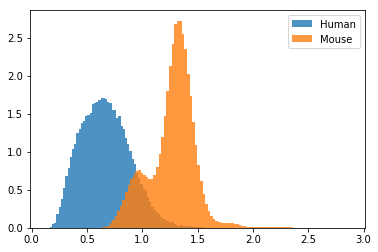

In [5]:
import matplotlib.pyplot as plt
plt.hist(human_tst_scores, bins=100, alpha=0.8, density=True, label='Human')
plt.hist(mouse_tst_scores, bins=100, alpha=0.8, density=True, label='Mouse')
plt.legend()
plt.show()

### 2.2.4 Save & Load

**`ablstm.ModelLSTM.save()`** saves model.

Parameters:

1. `fn`: Save file name.

**`ablstm.ModelLSTM.load()`** loads model from the given file. Please note that when `load()` method is invoked, all parameters will be overloaded except `device`. You may call `to()` method to switch among different devices.

Parameters:

1. `fn`: Load file name.

Returns:

1. Loaded model.

**`ablstm.ModelLSTM.to()`** reassigns device.

Parameters:

1. `device`: Device to mount.

In [8]:
# save model
model.save('./saved_models/tmp/model_tmp.npy')
print('Model saved to ./saved_models/tmp/model_tmp.npy.')

# load model
model_loaded = ModelLSTM()
model_loaded.load('./saved_models/tmp/model_tmp.npy')
print('Model loaded from ./saved_models/tmp/model_tmp.npy.')

# # data file names
# human_tst_fn = './data/sample/human_test_vlen.txt'
# mouse_tst_fn = './data/sample/mouse_test_vlen.txt'

# # evaluate
# print('Evaluating human sequences...')
# human_tst_scores = model_loaded.eval(fn=human_tst_fn, batch_size=512)
# print('Evaluating mouse sequences...')
# mouse_tst_scores = model_loaded.eval(fn=mouse_tst_fn, batch_size=512)
# print('Done.')

Model saved to ./saved_models/tmp/model_tmp.npy.
Model loaded from ./saved_models/tmp/model_tmp.npy.


### 2.3 Through command-line

### 2.3.1 Model configuration

Since neural network may have numerous parameters to configure that can appear excessively verbose if we pass all of them by commands. Most of the parameters, therefore, are stored in `ablstm.config` with XML format. The structure and the tag names exactly follow their corresponding Python class definition. Here is a sample XML configuration file. Please refer **section 2.2** for detailed description of those parameters.

```xml
<?xml version="1.0"?>
<ablstm>
    <__init__>
        <embedding_dim>64</embedding_dim>
        <hidden_dim>64</hidden_dim>
        <gapped>True</gapped>
        <fixed_len>True</fixed_len>
    </__init__>
    <fit>
        <n_epoch>8</n_epoch>
        <trn_batch_size>128</trn_batch_size>
        <vld_batch_size>512</vld_batch_size>
        <lr>0.002</lr>
    </fit>
    <eval>
        <batch_size>512</batch_size>
    </eval>
</ablstm>
```

### 2.3.2 Training

**Manuel**

```bash
usage: ablstm.py fit [-h] [-l L] [-c C] [-d D] TRN_FN VLD_FN SAVE_FP

positional arguments:
  TRN_FN      training data file
  VLD_FN      validation data file
  SAVE_FP     model save path

optional arguments:
  -h, --help  show this help message and exit
  -l L        model file to load (default: "")
  -c C        configuration XML file (default: "./ablstm.config")
  -d D        device (default: "cpu")
```

**Example**

If you want to start a fresh training:

```bash
> python ablstm.py fit ./data/sample/human_train.txt ./data/sample/human_val.txt ./saved_models/tmp
```

If you want to load a saved model and resume training:

```bash
> python ablstm.py fit ./data/sample/human_train.txt ./data/sample/human_val.txt ./saved_models/tmp -l ./saved_models/tmp/model_tmp.npy
```

If you want to point to a configuration file other than `ablstm.config`:
```bash
> python ablstm.py fit ./data/sample/human_train.txt ./data/sample/human_val.txt ./saved_models/tmp -c ./ablstm_new.config

```

### 2.3.3 Evaluation

**Manuel**

```bash
usage: ablstm.py eval [-h] [-c C] [-d D] TST_FN MDL_FN SCR_FN

positional arguments:
  TST_FN      evaluation data file
  MDL_FN      model file to load
  SCR_FN      file to save scores

optional arguments:
  -h, --help  show this help message and exit
  -c C        configuration XML file (default: "./ablstm.config")
  -d D        device (default: "cpu")
```

**Example**

```bash
> python ablstm.py eval ./data/sample/human_test.txt ./saved_models/tmp/model_tmp.npy ./results/result_human_test.txt
```